In [47]:
import re
import nltk
import tweepy
import pandas as pd
import seaborn as sns

from textblob import TextBlob
from translate import Translator
from nltk.tokenize import word_tokenize
from textblob.classifiers import NaiveBayesClassifier
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bilva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
bearer = "AAAAAAAAAAAAAAAAAAAAAK7DWgEAAAAAi7d0%2FnUXa55nietE%2BPkTa%2BGABHU%3DZDewMVcDnvjd0A01ZUWSYg9fhZlsiSLKN2XcX5RJ6C1bB1cZGn"
consumer_key = "a6qFeda7ma8e2kA0drlgpJqNJ"
consumer_secret = "ixrUzR5mbvj6ZbkvWAvhJid8uXNjRge40b6rWlqdcwMl4e3HTo" 
access_token = "1468548120808398850-Ka8T3Kg1GhRDTWvMa09Evq713lR2sF"
access_token_secret = "7U7XyOLrxRMugWvh3okIacE5fiCSaUFPOJBmz5tLzCwJc"

In [3]:
# Autentikasi
client = tweepy.Client(bearer_token=bearer, consumer_key=consumer_key, consumer_secret=consumer_secret, access_token=access_token, access_token_secret=access_token_secret)
result = client.search_recent_tweets("kualitas pendidikan", max_results=50)

In [7]:
# Data Preprocessing

def preprocess_text(text):
    # create stopword factory and stemmer factory
    stopword = StopWordRemoverFactory().create_stop_word_remover()
    stemmer = StemmerFactory().create_stemmer()
    # convert to lower case
    text = text.lower()
    # remove user handle
    text = re.sub("@[\w]*", "", text)
    # remove http links
    text = re.sub("http\S+", "", text)
    # remove digits and spl characters
    text = re.sub("[^a-zA-Z#0-9]", " ", text)
    # remove additional spaces
    text = re.sub("\s+", " ", text)
    text = stopword.remove(text)
    text = stemmer.stem(text)
    
    return text

def convert_eng(tweet):
    translator = Translator(to_lang='en', from_lang='id')
    translation = translator.translate(tweet)
    return translation

In [5]:
sentiment_data_all = result.data
final_data = []
sent_df = pd.DataFrame()
for sent_data  in sentiment_data_all:
    final_data.append(preprocess_text(sent_data.text))
sent_df['data_text'] = final_data
data_sent = list(sent_df['data_text'].apply(convert_eng))

In [9]:
polarization = 0

status = []
positive_tot = negative_tot = netral_tot = total = 0

for text in data_sent:
    analysis = TextBlob(text)
    polarization += analysis.polarity
    
    if analysis.sentiment.polarity > 0.0:
        positive_tot += 1
        status.append('Positive')
    elif analysis.sentiment.polarity == 0.0:
        netral_tot += 1
        status.append('Netral')
    else:
        negative_tot += 1
        status.append('Negative')
    total += 1

print(f"Positive: {positive_tot}\nNegative: {negative_tot}\nNetral: {netral_tot}")

Positive: 28
Negative: 14
Netral: 8


In [12]:
sent_df['eng_data'] = data_sent
sent_df['blob'] = status

In [1]:
sent_df

NameError: name 'sent_df' is not defined

In [14]:
dataset = sent_df.drop(['data_text'], axis=1, inplace=False)
dataset = [tuple(x) for x in dataset.to_records(index=False)]

In [26]:
len(dataset)

50

In [18]:
import random

set_positif = []
set_negatif = []
set_netral = []

for n in dataset:
    if(n[1] == 'Positive'):
      set_positif.append(n)
    elif(n[1] == 'Negative'):
      set_negatif.append(n)
    else:
      set_netral.append(n)

set_positif = random.sample(set_positif, k=int(len(set_positif)/2))
set_negatif = random.sample(set_negatif, k=int(len(set_negatif)/2))
set_netral = random.sample(set_netral, k=int(len(set_netral)/2))

train = set_positif + set_negatif + set_netral

train_set = []

for n in train:
     train_set.append(n)

In [29]:
len(set_negatif)

7

In [34]:
cl = NaiveBayesClassifier(train_set)
print("Akurasi Test: ", cl.accuracy(dataset))

Akurasi Test:  0.86


In [44]:
polarization = 0

status_nb = []
positive_tot = negative_tot = netral_tot = total = 0

for text in data_sent:
    analysis = TextBlob(text, classifier=cl)
    polarization += analysis.polarity
    
    if analysis.sentiment.polarity > 0.0:
        positive_tot += 1
        status_nb.append('Positive')
    elif analysis.sentiment.polarity == 0.0:
        netral_tot += 1
        status_nb.append('Netral')
    else:
        negative_tot += 1
        status_nb.append('Negative')
    total += 1

print(f"Positive: {positive_tot}\nNegative: {negative_tot}\nNetral: {netral_tot}")

Positive: 28
Negative: 14
Netral: 8


In [45]:
sent_df['naive_bayes_cl'] = status_nb

In [52]:
sent_df.to_csv("edu_sentiment.csv", index=False)

<Axes: xlabel='naive_bayes_cl', ylabel='count'>

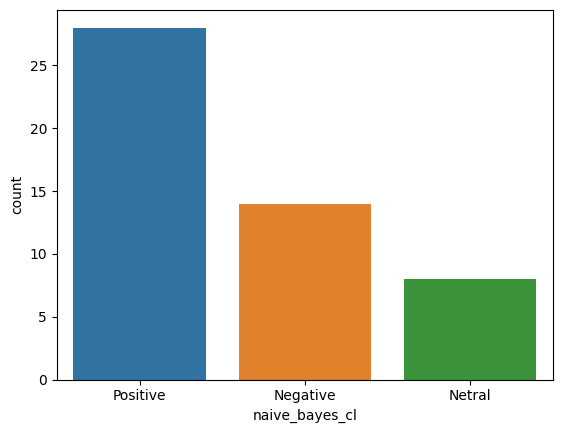

In [51]:
sns.countplot(data=sent_df, x=sent_df['naive_bayes_cl'], hue='naive_bayes_cl')